In [22]:
!pip install category_encoders
!pip install catboost

In [23]:
# Load all helper function
%run -i '../util/helper.py'

In [24]:
import pandas as pd

# Load Dataset and Data Split

In [25]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [26]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [27]:
print(X_dev.shape)
print(X_test.shape)

(92506, 30)
(23127, 30)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [28]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start4 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}

pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])

pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev, np.ravel(y_dev))
end4 = time()
print("CatBoost model takes " + str(end4-start4) + "seconds")

0:	learn: 0.6233738	total: 29.6ms	remaining: 2.92s
1:	learn: 0.5717696	total: 57.8ms	remaining: 2.83s
2:	learn: 0.5225638	total: 83.2ms	remaining: 2.69s
3:	learn: 0.4785330	total: 111ms	remaining: 2.67s
4:	learn: 0.4426450	total: 138ms	remaining: 2.62s
5:	learn: 0.4130681	total: 166ms	remaining: 2.6s
6:	learn: 0.3876097	total: 194ms	remaining: 2.58s
7:	learn: 0.3644688	total: 222ms	remaining: 2.55s
8:	learn: 0.3436317	total: 252ms	remaining: 2.55s
9:	learn: 0.3254612	total: 279ms	remaining: 2.51s
10:	learn: 0.3113275	total: 305ms	remaining: 2.47s
11:	learn: 0.2992051	total: 331ms	remaining: 2.43s
12:	learn: 0.2865879	total: 359ms	remaining: 2.4s
13:	learn: 0.2788660	total: 385ms	remaining: 2.37s
14:	learn: 0.2693440	total: 420ms	remaining: 2.38s
15:	learn: 0.2611111	total: 445ms	remaining: 2.33s
16:	learn: 0.2538149	total: 476ms	remaining: 2.32s
17:	learn: 0.2477231	total: 503ms	remaining: 2.29s
18:	learn: 0.2443156	total: 544ms	remaining: 2.32s
19:	learn: 0.2392709	total: 572ms	remain

ValueError: ignored

In [57]:
from sklearn.metrics import accuracy_score
y_pred = grid_search_CB.best_estimator_.predict(X_test).astype("bool")
print("The performance of the CatBoost model on test data is ", accuracy_score(y_test, y_pred))
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)

The performance of the CatBoost model on test data is  0.07536645479309897
The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [55]:
CB_prediction = pipe_CB.predict(X_test).astype("bool")

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.07536645479309897
Recall: 1.0
Precision: 0.07536645479309897
F-1 Score: 0.14016887816646562


[ True  True  True ...  True  True  True]


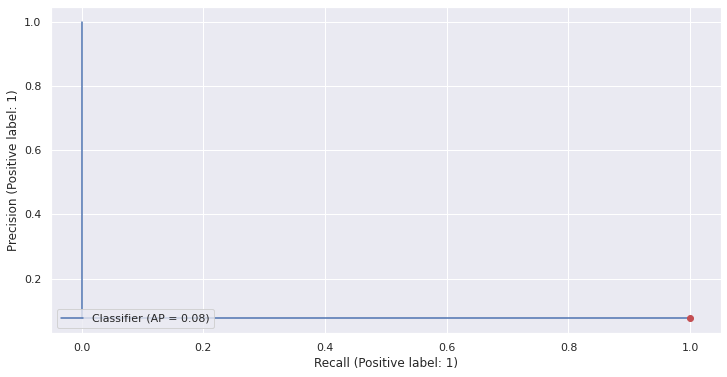

In [37]:
probs = pipe_CB.predict_proba(X_test).astype("bool")[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

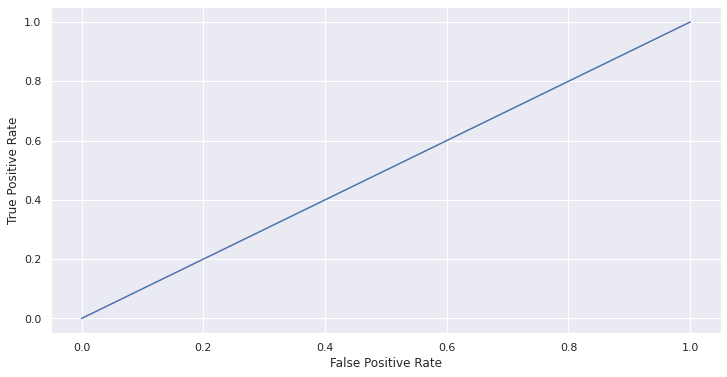

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [39]:
filename = '../model/CatBoost_stratified.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))

FileNotFoundError: ignored

## Downsampling

In [40]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [47]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start5 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}
pipe_CB_tune = Pipeline([('classifier',CatBoostClassifier(random_state=random_state))])
pipe_CB = make_pipeline(GridSearchCV(pipe_CB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_CB.fit(X_dev_us, np.ravel(y_dev_us))
end5 = time()
print("CatBoost model takes " + str(end5-start5) + "seconds")

0:	learn: 0.6747757	total: 9.46ms	remaining: 937ms
1:	learn: 0.6563478	total: 17.7ms	remaining: 867ms
2:	learn: 0.6394946	total: 25.6ms	remaining: 827ms
3:	learn: 0.6256803	total: 33.7ms	remaining: 809ms
4:	learn: 0.6129460	total: 42.7ms	remaining: 811ms
5:	learn: 0.6013534	total: 50.5ms	remaining: 792ms
6:	learn: 0.5913431	total: 59ms	remaining: 784ms
7:	learn: 0.5815660	total: 66.9ms	remaining: 769ms
8:	learn: 0.5712939	total: 74.6ms	remaining: 754ms
9:	learn: 0.5637271	total: 82.4ms	remaining: 741ms
10:	learn: 0.5557687	total: 90.5ms	remaining: 733ms
11:	learn: 0.5497460	total: 98.9ms	remaining: 725ms
12:	learn: 0.5449925	total: 108ms	remaining: 720ms
13:	learn: 0.5398694	total: 116ms	remaining: 712ms
14:	learn: 0.5345762	total: 124ms	remaining: 704ms
15:	learn: 0.5303604	total: 133ms	remaining: 697ms
16:	learn: 0.5265281	total: 141ms	remaining: 689ms
17:	learn: 0.5219135	total: 150ms	remaining: 683ms
18:	learn: 0.5193755	total: 158ms	remaining: 675ms
19:	learn: 0.5150202	total: 167

In [53]:
pipe_CB.score(X_test, y_test)

TypeError: ignored

In [48]:
from sklearn.metrics import f1_score, recall_score
y_pred = pipe_CB.predict(X_test).astype("bool")
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("The performance of the CatBoost model on test data is ", {'f1_score': f1, 'recall_score': recall})
grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
print(f"The CatBoost model Best hyperparameters is ", grid_search_CB.best_params_)
# print("The performance of the CatBoost model on test data is ", pipe_CB.score(X_test, y_test))
# grid_search_CB = pipe_CB.named_steps["gridsearchcv"]
# print(f"The CatBoost model best hyperparameters is ", grid_search_CB.best_params_)

The performance of the CatBoost model on test data is  {'f1_score': 0.14016887816646562, 'recall_score': 1.0}
The CatBoost model Best hyperparameters is  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__n_estimators': 100}


### Evaluate on the Test Set

In [49]:
CB_prediction = pipe_CB.predict(X_test).astype("bool")

print(f'Accuracy: {accuracy_score(y_test,CB_prediction)}')
print(f'Recall: {recall_score(y_test,CB_prediction)}')
print(f'Precision: {precision_score(y_test,CB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,CB_prediction)}')

recall, precision = recall_score(y_test,CB_prediction), precision_score(y_test,CB_prediction)

Accuracy: 0.07536645479309897
Recall: 1.0
Precision: 0.07536645479309897
F-1 Score: 0.14016887816646562


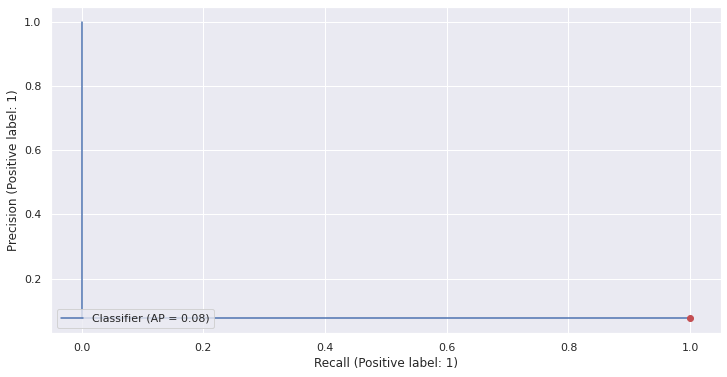

In [50]:
probs = pipe_CB.predict_proba(X_test).astype("bool")[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

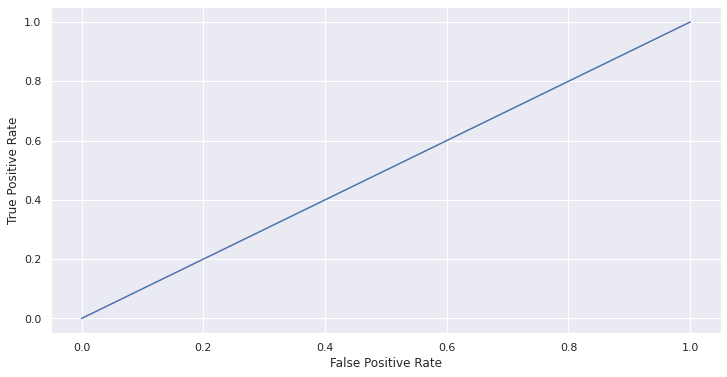

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [52]:
filename = '../Model/CatBoost_downsampling.sav'
pickle.dump(pipe_CB, open(filename, 'wb'))

FileNotFoundError: ignored